# **Projeto da Monografia**

Tema: Comparação de desempenho entre DenseNet treinada como Autoencoder e treinada normalmente.

In [1]:
import os
import random
import json
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
import matplotlib.cm as cm

import cv2

import tensorflow as tf
import keras
from tensorflow import GradientTape
from tensorflow.keras import mixed_precision, layers, Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Walking through directories
for dirpath, dirnames, filenames in os.walk("SiDi_BreakHis400x_Balanceado/train_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print('\n')
for dirpath, dirnames, filenames in os.walk("SiDi_BreakHis400x_Balanceado/validation_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'SiDi_BreakHis400x_Balanceado/train_set/'.
There are 0 directories and 1037 images in 'SiDi_BreakHis400x_Balanceado/train_set/benign'.
There are 0 directories and 1037 images in 'SiDi_BreakHis400x_Balanceado/train_set/malignant'.


There are 2 directories and 0 images in 'SiDi_BreakHis400x_Balanceado/validation_set/'.
There are 0 directories and 180 images in 'SiDi_BreakHis400x_Balanceado/validation_set/benign'.
There are 0 directories and 180 images in 'SiDi_BreakHis400x_Balanceado/validation_set/malignant'.


In [4]:
# loading directories
ae_dir = 'BreakHis400x_AE/'
train_dir = 'SiDi_BreakHis400x_Balanceado/train_set/'
val_dir = 'SiDi_BreakHis400x_Balanceado/validation_set/'
test_dir = 'SiDi_BreCaHAD_test/dataset/'
test_dir_ae = 'SiDi_BreCaHAD_test/dataset/malignant/'
annotated_dir = 'SiDi_BreCaHAD_test/groundTruth_display/'

In [5]:
IMG_SIZE=(128,128)
BATCH = 32
# IMG_SIZE=(160,160)

train_ae = tf.keras.preprocessing.image_dataset_from_directory(directory=ae_dir, image_size=IMG_SIZE, 
                                                                 label_mode=None, batch_size=BATCH, seed=42, subset='training',
                                                              validation_split=0.3)
val_ae = tf.keras.preprocessing.image_dataset_from_directory(directory=ae_dir, image_size=IMG_SIZE, 
                                                               label_mode=None, batch_size=BATCH, seed=42, subset='validation',
                                                            validation_split=0.3)
test_ae = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_ae, image_size=IMG_SIZE,
                                                             label_mode=None, batch_size=BATCH)

Found 1365 files belonging to 1 classes.
Using 956 files for training.
Found 1365 files belonging to 1 classes.
Using 409 files for validation.
Found 159 files belonging to 1 classes.


In [6]:
# loading data
IMG_SIZE=(128,128)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, image_size=IMG_SIZE, 
                                                                 label_mode='categorical', batch_size=32)
val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir, image_size=IMG_SIZE, 
                                                               label_mode='categorical', batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMG_SIZE, 
                                                               label_mode='categorical', batch_size=32)

Found 2074 files belonging to 2 classes.
Found 360 files belonging to 2 classes.
Found 159 files belonging to 2 classes.


In [7]:
class_names = train_data.class_names
class_names

['benign', 'malignant']

In [8]:
# Function to see random image
def view_random_image(target_dir):
    
    # Get a random image path
    random_image = random.sample(os.listdir(target_dir), 1)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_dir + random_image[0])
    plt.imshow(img)
    plt.title(f'{target_dir.split("/")[1]}\n{img.shape}')
    plt.axis('off');
    
    return img

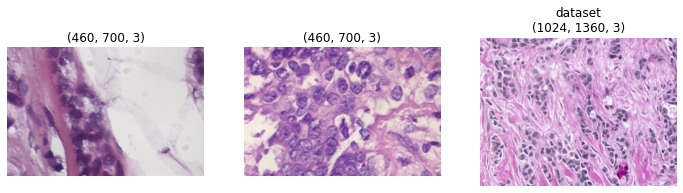

In [9]:
# view random image from training dataset
plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
img1 = view_random_image('BreakHis400x_AE/')

plt.subplot(1,3,2)
img2 = view_random_image('BreakHis400x_AE/')

plt.subplot(1,3,3)
img3 = view_random_image('SiDi_BreCaHAD_test/dataset/malignant/')

## Creating Modelling Callbacks 

In [10]:
# Setup Earlystopping callback to stop training if model's val_accuracy doesn't improve for 5 epochs
ea = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0.001, patience=30)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9)

## Setting Mixed Precision

In [11]:
# turn on mixed precision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


## Batch Configuration

In [12]:
train_dt, val_dt, test_dt = [], [], []

for images in train_ae.unbatch():
    train_dt.append(images)
    
for images in val_ae.unbatch():
    val_dt.append(images)

for images in test_ae.unbatch():
    test_dt.append(images)

In [13]:
x_train = np.reshape(train_dt, (len(train_dt), 128, 128, 3))
x_val = np.reshape(val_dt, (len(val_dt), 128, 128, 3))
x_test = np.reshape(test_dt, (len(test_dt), 128, 128, 3))

In [14]:
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.

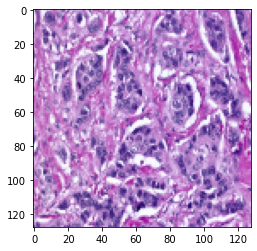

In [15]:
plt.imshow(x_test[0].astype(np.uint8))

## Building Model 

In [16]:
#Convolutional block to be used in autoencoder and U-Net
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

In [17]:
#Encoder block: Conv block followed by maxpooling
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return p, x

In [18]:
#Decoder block for autoencoder (no skip connections)
def decoder_block(inputs, num_filters, linear=False):
    
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = conv_block(x, num_filters)
#     x = conv_block(x, 1)
#     x = conv_block(x, num_filters)
#     x = conv_block(x, 1)
    
    return x

In [19]:
# dense = tf.keras.applications.DenseNet121(include_top=False, input_tensor=(tf.keras.Input((128,128,3))), pooling="max", weights='imagenet')

In [20]:
# efficient.summary()

In [21]:
def build_encoder(input_layer, mobile_type = False):
    #inputs = Input(input_shape)
    
    if mobile_type == False:
        p1, s1 = encoder_block(input_layer, 8)
        p2, s2 = encoder_block(p1, 16)
        p3, s3 = encoder_block(p2, 32)
        p4, s4 = encoder_block(p3, 64)
        p5, s5 = encoder_block(p4, 128)

        encoded = conv_block(p5, 512, name='Bridge') #Bridge
    
    else:
#         inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
        dense = tf.keras.applications.DenseNet121(include_top=False, input_tensor=input_layer, pooling="max", weights='imagenet')
        
        # To begin fine-tuning, let's start setting the last 10 layers of our base_model.trainable = True
        dense.trainable = True

        # Freeze again all layers except the last 10
#         for layer in mobile.layers[:-7]:
#             layer.trainable = False
        
        dense.layers[-2]._name = 'BRIDGE'
        encoded = dense.layers[-2].output # Bridge
    
    return encoded

In [22]:
#Decoder for Autoencoder ONLY. 
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)
    d5 = decoder_block(d4, 16)
    
    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d5)
    
    return decoded

## Experiment 1: DenseNet with ImageNet Weights

In [23]:
#Use encoder and decoder blocks to build the autoencoder. 
def build_autoencoder(input_shape):
    
    input_img = tf.keras.layers.Input(shape=input_shape, name='input_layer')
#     encoder = keras.Model(input_img, build_encoder(input_img, True), name='Encoder')
#     decoder = keras.Model(encoder.output, build_decoder(encoder.output))
    autoencoder = keras.Model(input_img, build_decoder(build_encoder(input_img, True)), name='Auto_Encoder_Dense')
    
    return autoencoder

In [24]:
# input_img = keras.Input(shape=(224, 224, 3), name='input_layer')
autoencoder = build_autoencoder((128,128,3))
# encoder, autoencoder = build_autoencoder((160,160,3))
# encoder.summary()

In [25]:
autoencoder.summary()

Model: "Auto_Encoder_Dense"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_layer[0][0]']            
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][

In [27]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

In [28]:
history = autoencoder.fit(x_train, x_train, epochs=70, batch_size=BATCH, shuffle=False, validation_data=(x_val, x_val), 
                         callbacks=[reduce_lr])

Epoch 1/70
30/30 [==============================] - 73s 1s/step - loss: 0.6955 - val_loss: 0.6866 - lr: 0.0010
Epoch 2/70
30/30 [==============================] - 34s 1s/step - loss: 0.6655 - val_loss: 0.6681 - lr: 0.0010
Epoch 3/70
30/30 [==============================] - 34s 1s/step - loss: 0.6444 - val_loss: 0.6445 - lr: 0.0010
Epoch 4/70
30/30 [==============================] - 34s 1s/step - loss: 0.6286 - val_loss: 0.6273 - lr: 0.0010
Epoch 5/70
30/30 [==============================] - 34s 1s/step - loss: 0.6170 - val_loss: 0.6179 - lr: 0.0010
Epoch 6/70
30/30 [==============================] - 34s 1s/step - loss: 0.6095 - val_loss: 0.6123 - lr: 0.0010
Epoch 7/70
30/30 [==============================] - 34s 1s/step - loss: 0.6053 - val_loss: 0.6089 - lr: 0.0010
Epoch 8/70
30/30 [==============================] - 34s 1s/step - loss: 0.6027 - val_loss: 0.6069 - lr: 0.0010
Epoch 9/70
30/30 [==============================] - 35s 1s/step - loss: 0.6007 - val_loss: 0.6146 - lr: 0.0010
E

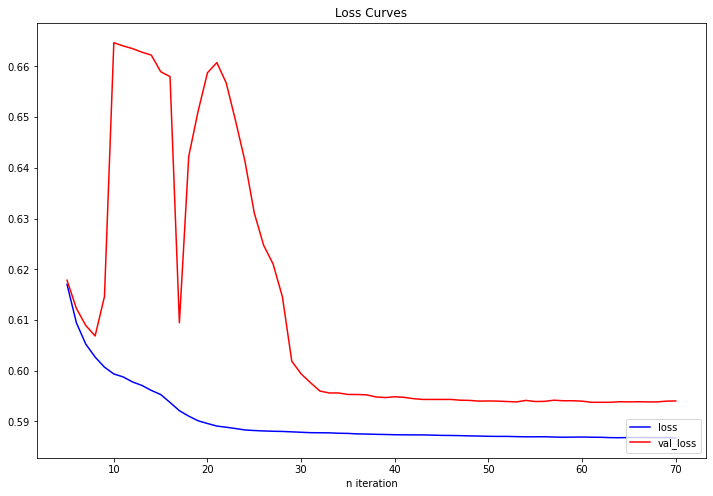

In [29]:
# Plotting Loss Curver
plt.figure(figsize=(12,8))

x_values = np.arange(1,71,1)

plt.plot(x_values[4:], history.history['loss'][4:], '-b', label='loss')
plt.plot(x_values[4:], history.history['val_loss'][4:], '-r', label='val_loss')

plt.xlabel("n iteration")
plt.legend(loc='lower right')
plt.title("Loss Curves")

# show
plt.show()

In [33]:
preds = autoencoder.predict(x_test)
pred_u8 = (preds[1]*255).astype(np.uint8)
orig_u8 = x_test[1].astype(np.uint8)

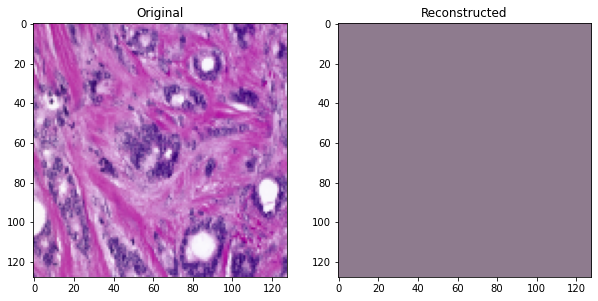

In [34]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(orig_u8)
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(pred_u8)
plt.title('Reconstructed')

plt.show()

### Salvando O Modelo

In [32]:
autoencoder.save('saved_model/densenet/dense_autoencoder_imagenet_weights')

INFO:tensorflow:Assets written to: saved_model/densenet/dense_autoencoder_imagenet_weights\assets


## Experiment 2: DenseNet with Random Weights

In [23]:
def build_encoder_2(input_layer, mobile_type = False):
    #inputs = Input(input_shape)
    
    if mobile_type == False:
        p1, s1 = encoder_block(input_layer, 8)
        p2, s2 = encoder_block(p1, 16)
        p3, s3 = encoder_block(p2, 32)
        p4, s4 = encoder_block(p3, 64)
        p5, s5 = encoder_block(p4, 128)

        encoded = conv_block(p5, 512) #Bridge
    
    else:
#         inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
        dense = tf.keras.applications.DenseNet121(include_top=False, input_tensor=input_layer, pooling="max", weights=None)
        
        # To begin fine-tuning, let's start setting the last 10 layers of our base_model.trainable = True
        dense.trainable = True

        # Freeze again all layers except the last 10
#         for layer in mobile.layers[:-7]:
#             layer.trainable = False
        
        dense.layers[-2]._name = 'BRIDGE'
        encoded = dense.layers[-2].output # Bridge
    
    return encoded

In [24]:
def build_autoencoder_2(input_shape):
    
    input_img = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    encoder = keras.Model(input_img, build_encoder_2(input_img, True), name='Encoder_Random')
    decoder = keras.Model(encoder.output, build_decoder(encoder.output))
    autoencoder = keras.Model(input_img, build_decoder(build_encoder_2(input_img, True)), name='Auto_Encoder_Random')
    
    return encoder, autoencoder

In [25]:
# input_img = keras.Input(shape=(224, 224, 3), name='input_layer')
encoder_2, autoencoder_2 = build_autoencoder_2((128,128,3))
# encoder, autoencoder = build_autoencoder((160,160,3))
encoder_2.summary()

Model: "Encoder_Random"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_layer[0][0]']            
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']

In [26]:
autoencoder_2.summary()

Model: "Auto_Encoder_Random"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 134, 134, 3)  0          ['input_layer[0][0]']            
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                

In [27]:
autoencoder_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

In [28]:
history_2 = autoencoder_2.fit(x_train, x_train, epochs=70, batch_size=32, shuffle=False, validation_data=(x_val, x_val),  
                         callbacks=[reduce_lr])

Epoch 1/70
30/30 [==============================] - 65s 1s/step - loss: 0.6157 - val_loss: 0.6640 - lr: 0.0010
Epoch 2/70
30/30 [==============================] - 29s 953ms/step - loss: 0.5853 - val_loss: 0.6472 - lr: 0.0010
Epoch 3/70
30/30 [==============================] - 29s 954ms/step - loss: 0.5837 - val_loss: 0.6454 - lr: 0.0010
Epoch 4/70
30/30 [==============================] - 28s 953ms/step - loss: 0.5823 - val_loss: 0.6346 - lr: 0.0010
Epoch 5/70
30/30 [==============================] - 29s 954ms/step - loss: 0.5812 - val_loss: 0.6278 - lr: 0.0010
Epoch 6/70
30/30 [==============================] - 29s 954ms/step - loss: 0.5807 - val_loss: 0.5931 - lr: 0.0010
Epoch 7/70
30/30 [==============================] - 28s 953ms/step - loss: 0.5792 - val_loss: 0.5987 - lr: 0.0010
Epoch 8/70
30/30 [==============================] - 29s 954ms/step - loss: 0.5781 - val_loss: 0.6137 - lr: 0.0010
Epoch 9/70
30/30 [==============================] - 29s 956ms/step - loss: 0.5775 - val_los

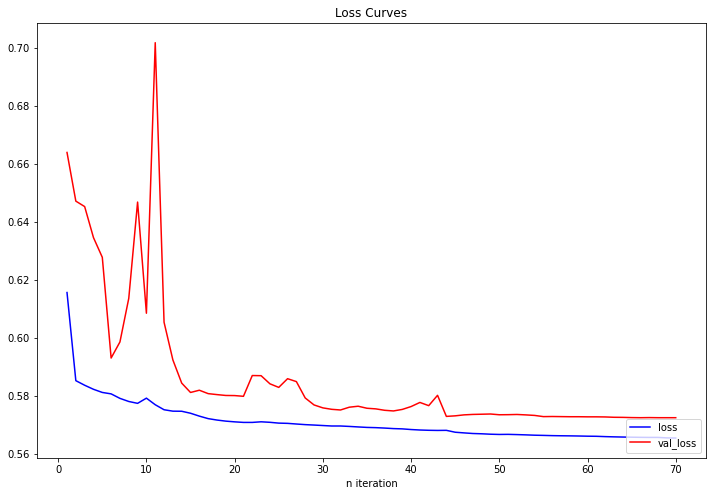

In [29]:
# Plotting Loss Curver
plt.figure(figsize=(12,8))

x_values = np.arange(1,71,1)

plt.plot(x_values, history_2.history['loss'], '-b', label='loss')
plt.plot(x_values, history_2.history['val_loss'], '-r', label='val_loss')

plt.xlabel("n iteration")
plt.legend(loc='lower right')
plt.title("Loss Curves")

# show
plt.show()

In [32]:
preds2 = autoencoder_2.predict(x_test)
pred2_u8 = (preds2[0]*255).astype(np.uint8)
orig2_u8 = x_test[0].astype(np.uint8)

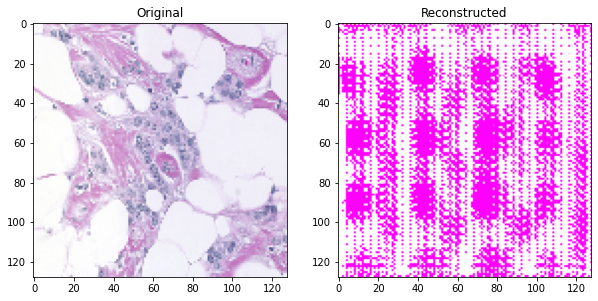

In [33]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(orig2_u8)
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(pred2_u8)
plt.title('Reconstructed')

plt.show()

### Salvando O Modelo

In [34]:
autoencoder_2.save('saved_model/densenet/dense_autoencoder_random_weights')

INFO:tensorflow:Assets written to: saved_model/densenet/dense_autoencoder_random_weights\assets


## Adding MLPs to Classification

In [23]:
from helper_functions import make_confusion_matrix, plot_loss_curves

In [24]:
# true labels
test_labels = []
for _, label in test_data.unbatch():
    test_labels.append(label)
y_true = np.ones((159,), dtype='int8')

### DenseNet Vanilla

In [42]:
# Create Base Model
input_shape = (128,128,3)

# Create Functional Model

inputs = layers.Input(shape=input_shape, name='input_layer')
base_den = tf.keras.applications.DenseNet121(include_top=False, input_tensor=inputs, weights='imagenet')
base_den.trainable = False
x = layers.GlobalAveragePooling2D()(base_den.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

outputs = layers.Dense(2, activation='softmax', dtype = tf.float32, name='softmax_float_32')(x)
model_vanilla = tf.keras.Model(inputs, outputs, name='DenseNet_Vanilla')

# compiling the model
model_vanilla.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

In [43]:
model_vanilla.summary()

Model: "DenseNet_Vanilla"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 134, 134, 3)  0          ['input_layer[0][0]']            
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d_4[0][0]']       
                                                                                   

In [44]:
# Fitting the model

history_base = model_vanilla.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=val_data, validation_steps=len(val_data),
                                 callbacks=[reduce_lr, ea], validation_batch_size=32)

Epoch 1/100
65/65 [==============================] - 27s 263ms/step - loss: 0.5511 - accuracy: 0.7117 - val_loss: 0.6792 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 2/100
65/65 [==============================] - 16s 230ms/step - loss: 0.4430 - accuracy: 0.7801 - val_loss: 0.6050 - val_accuracy: 0.7194 - lr: 0.0100
Epoch 3/100
65/65 [==============================] - 16s 230ms/step - loss: 0.3907 - accuracy: 0.8216 - val_loss: 0.5489 - val_accuracy: 0.7528 - lr: 0.0100
Epoch 4/100
65/65 [==============================] - 16s 232ms/step - loss: 0.3791 - accuracy: 0.8255 - val_loss: 0.5336 - val_accuracy: 0.7667 - lr: 0.0100
Epoch 5/100
65/65 [==============================] - 15s 228ms/step - loss: 0.3517 - accuracy: 0.8467 - val_loss: 0.4898 - val_accuracy: 0.7833 - lr: 0.0100
Epoch 6/100
65/65 [==============================] - 15s 224ms/step - loss: 0.3475 - accuracy: 0.8472 - val_loss: 0.4761 - val_accuracy: 0.7861 - lr: 0.0100
Epoch 7/100
65/65 [==============================] - 15s 2

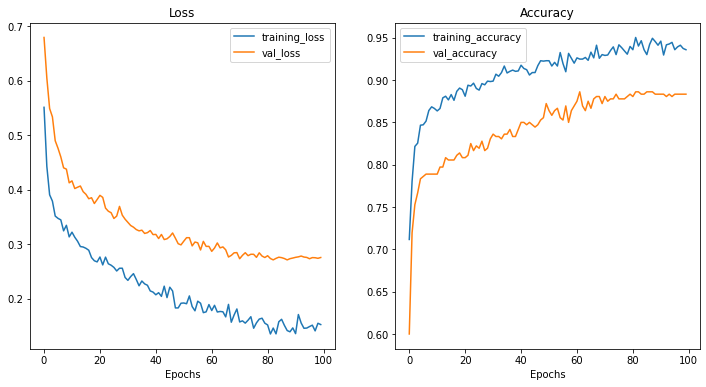

In [45]:
# plotting loss curves
plot_loss_curves(history_base)

In [46]:
model_vanilla.evaluate(test_data)

5/5 [==============================] - 3s 170ms/step - loss: 0.4462 - accuracy: 0.8050


[0.4461766481399536, 0.805031418800354]

In [47]:
model_vanilla_preds_probs = model_vanilla.predict(test_data)

In [48]:
model_vanilla_preds = tf.argmax(model_vanilla_preds_probs, axis=1)

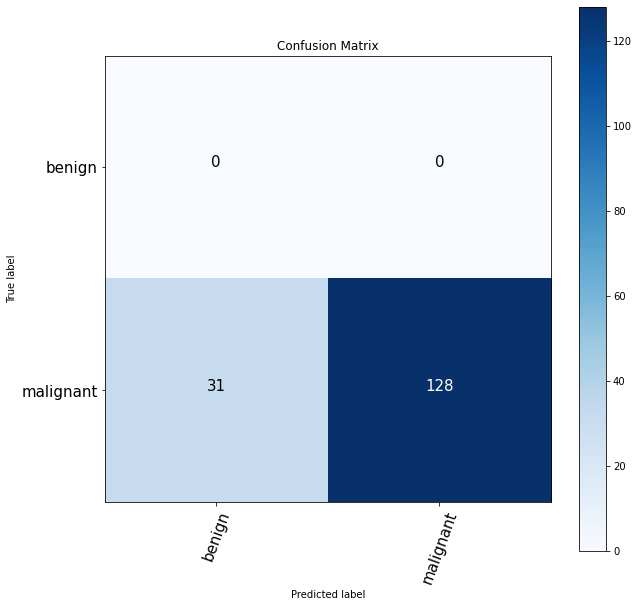

In [49]:
make_confusion_matrix(y_true, model_vanilla_preds, test_data.class_names)

In [50]:
# saving vanilla model

model_vanilla.save('saved_model/models/dense_vanilla')

INFO:tensorflow:Assets written to: saved_model/models/dense_vanilla\assets


### DenseNet Encoded with Random Weights

In [51]:
# loading and setting the random weights encoder
encoder_random = tf.keras.models.load_model('saved_model/densenet/dense_autoencoder_random_weights/')

# base model
dense_re = tf.keras.Model(encoder_random.input, encoder_random.get_layer('BRIDGE').output, name='Encoder_Random')
dense_re.trainable = False

dense_re.summary()

Model: "Encoder_Random"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 134, 134, 3)  0          ['input_layer[0][0]']            
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                     

In [52]:
# adding the mlp top
# Create Base Model
input_shape = (128,128,3)

# Create Functional Model

x = layers.GlobalAveragePooling2D()(dense_re.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(2, activation='softmax', dtype = tf.float32, name='softmax_float_32')(x)

# Random weights model
model_drw = tf.keras.Model(dense_re.input, outputs, name='DenseNet_Random_Weights')

# compiling the model
model_drw.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

In [53]:
model_drw.summary()

Model: "DenseNet_Random_Weights"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 134, 134, 3)  0          ['input_layer[0][0]']            
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                            

In [54]:
# Fitting the model

history_drw = model_drw.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=val_data, validation_steps=len(val_data), 
                                 callbacks=[reduce_lr, ea])

Epoch 1/100
65/65 [==============================] - 26s 259ms/step - loss: 0.6317 - accuracy: 0.6755 - val_loss: 0.6328 - val_accuracy: 0.7139 - lr: 0.0100
Epoch 2/100
65/65 [==============================] - 15s 224ms/step - loss: 0.4106 - accuracy: 0.8202 - val_loss: 0.7206 - val_accuracy: 0.5167 - lr: 0.0100
Epoch 3/100
65/65 [==============================] - 15s 223ms/step - loss: 0.3560 - accuracy: 0.8573 - val_loss: 0.6822 - val_accuracy: 0.6611 - lr: 0.0100
Epoch 4/100
65/65 [==============================] - 15s 222ms/step - loss: 0.3699 - accuracy: 0.8563 - val_loss: 0.6214 - val_accuracy: 0.7028 - lr: 0.0100
Epoch 5/100
65/65 [==============================] - 15s 222ms/step - loss: 0.3592 - accuracy: 0.8597 - val_loss: 0.5814 - val_accuracy: 0.7722 - lr: 0.0100
Epoch 6/100
65/65 [==============================] - 15s 221ms/step - loss: 0.3550 - accuracy: 0.8650 - val_loss: 0.5636 - val_accuracy: 0.7861 - lr: 0.0100
Epoch 7/100
65/65 [==============================] - 15s 2

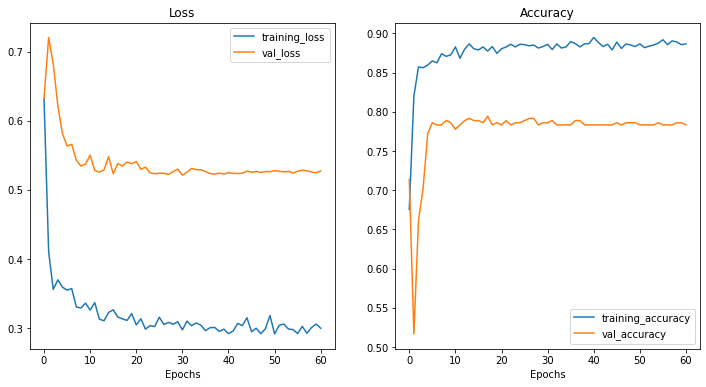

In [55]:
# plotting loss curves
plot_loss_curves(history_drw)

In [56]:
model_drw.evaluate(test_data)

5/5 [==============================] - 4s 175ms/step - loss: 0.2853 - accuracy: 0.9182


[0.2853397727012634, 0.9182389974594116]

In [57]:
model_drw_preds_probs = model_drw.predict(test_data)

In [58]:
model_drw_preds = tf.argmax(model_drw_preds_probs, axis=1)

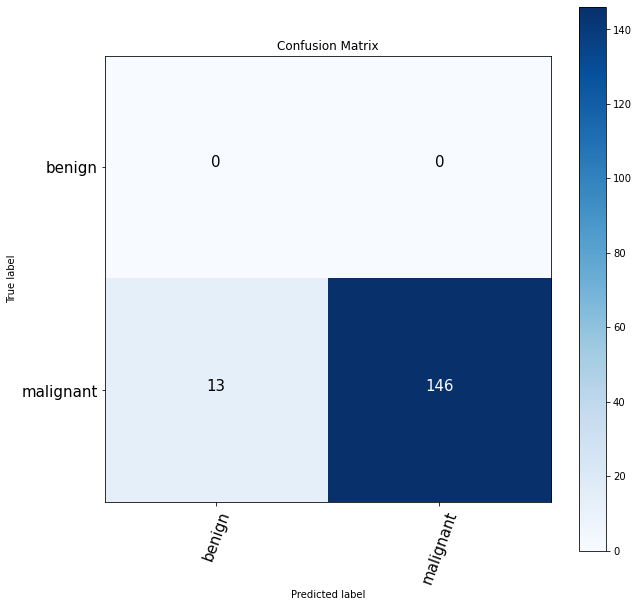

In [59]:
make_confusion_matrix(y_true, model_drw_preds, test_data.class_names)

In [60]:
# saving vanilla model

model_drw.save('saved_model/models/dense_rand_weights')

INFO:tensorflow:Assets written to: saved_model/models/dense_rand_weights\assets


### DenseNet Encoded with ImageNet Weights

In [61]:
# loading and setting the random weights encoder
encoder_imagenet = tf.keras.models.load_model('saved_model/densenet/dense_autoencoder_imagenet_weights/')

# base model
dense_ie = tf.keras.Model(encoder_imagenet.input, encoder_imagenet.get_layer('BRIDGE').output, name='Encoder_ImageNet')
dense_ie.trainable = True

dense_ie.summary()

Model: "Encoder_ImageNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_layer[0][0]']            
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]

In [62]:
# adding the mlp top
# Create Base Model
input_shape = (128,128,3)

# Create Functional Model

x = layers.GlobalAveragePooling2D()(dense_ie.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(2, activation='softmax', dtype = tf.float32, name='softmax_float_32')(x)

# Random weights model
model_diw = tf.keras.Model(dense_ie.input, outputs, name='DenseNet_ImageNet_Weights')

# compiling the model
model_diw.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

In [63]:
model_diw.summary()

Model: "DenseNet_ImageNet_Weights"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_layer[0][0]']            
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/c

In [64]:
# Fitting the model
history_diw = model_diw.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=val_data, validation_steps=len(val_data), 
                                 callbacks=[reduce_lr, ea])

Epoch 1/100
65/65 [==============================] - 71s 663ms/step - loss: 0.5190 - accuracy: 0.7560 - val_loss: 0.6711 - val_accuracy: 0.6111 - lr: 0.0100
Epoch 2/100
65/65 [==============================] - 41s 622ms/step - loss: 0.3850 - accuracy: 0.8216 - val_loss: 0.7089 - val_accuracy: 0.6083 - lr: 0.0100
Epoch 3/100
65/65 [==============================] - 41s 620ms/step - loss: 0.3170 - accuracy: 0.8582 - val_loss: 0.6976 - val_accuracy: 0.6861 - lr: 0.0100
Epoch 4/100
65/65 [==============================] - 41s 619ms/step - loss: 0.2907 - accuracy: 0.8761 - val_loss: 0.4978 - val_accuracy: 0.7778 - lr: 0.0100
Epoch 5/100
65/65 [==============================] - 41s 618ms/step - loss: 0.2592 - accuracy: 0.8833 - val_loss: 0.3741 - val_accuracy: 0.8306 - lr: 0.0100
Epoch 6/100
65/65 [==============================] - 41s 619ms/step - loss: 0.2344 - accuracy: 0.9021 - val_loss: 0.3138 - val_accuracy: 0.8556 - lr: 0.0100
Epoch 7/100
65/65 [==============================] - 41s 6

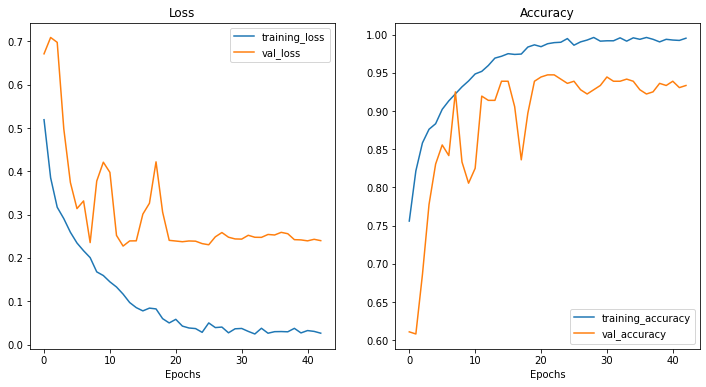

In [65]:
# plotting loss curves
plot_loss_curves(history_diw)

In [66]:
model_diw.evaluate(test_data)

5/5 [==============================] - 4s 177ms/step - loss: 0.0777 - accuracy: 0.9686


[0.07771576195955276, 0.9685534834861755]

In [67]:
model_diw_preds_probs = model_diw.predict(test_data)

In [68]:
model_diw_preds = tf.argmax(model_diw_preds_probs, axis=1)

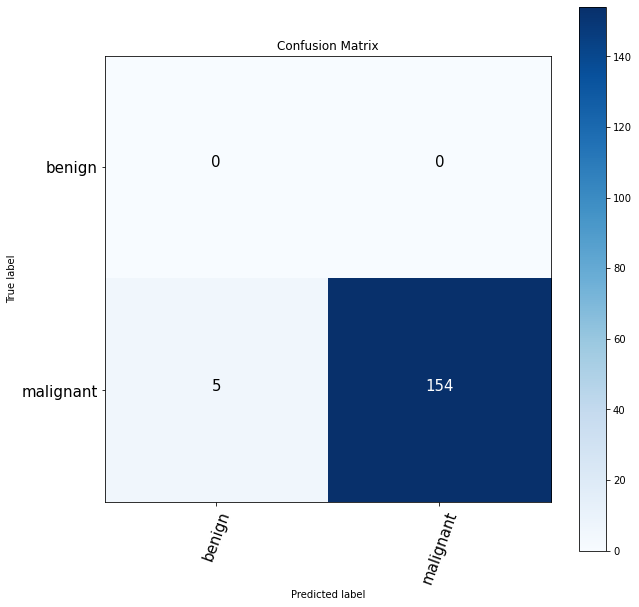

In [69]:
make_confusion_matrix(y_true, model_diw_preds, test_data.class_names)

In [71]:
# saving vanilla model

model_diw.save('saved_model/models/dense_imagenet_weights')

INFO:tensorflow:Assets written to: saved_model/models/dense_imagenet_weights\assets


## Interpretability of the Models

In [72]:
import interpretability_data as it

In [73]:
# Generating Dataframes

df_vanilla = it.generating_dataset(model_vanilla, 'BreCaHAD_test_png/', 'SiDi_BreCaHAD_test/groundTruth/', class_names)
df_drw = it.generating_dataset(model_drw, 'BreCaHAD_test_png/', 'SiDi_BreCaHAD_test/groundTruth/', class_names)
df_diw = it.generating_dataset(model_diw, 'BreCaHAD_test_png/', 'SiDi_BreCaHAD_test/groundTruth/', class_names)

In [74]:
df_vanilla.head()

Case Total Tumor Cells Pred. Type Probability (%) Tumors Found  \
0  Case_1-01               140  malignant           90.48           14   
1  Case_1-02               153  malignant            95.5           22   
2  Case_1-03               135     benign           51.72           84   
3  Case_1-04               103  malignant           93.03           21   
4  Case_1-05               126  malignant           94.65           20   

  Interpret. Region Accuracy (%)  
0                           10.0  
1                          14.38  
2                              0  
3                          20.39  
4                          15.87

In [75]:
df_drw.head()

Case Total Tumor Cells Pred. Type Probability (%) Tumors Found  \
0  Case_1-01               140  malignant           79.42          134   
1  Case_1-02               153  malignant           83.38           83   
2  Case_1-03               135  malignant           82.28           18   
3  Case_1-04               103  malignant           86.71           39   
4  Case_1-05               126  malignant           83.48           14   

  Interpret. Region Accuracy (%)  
0                          95.71  
1                          54.25  
2                          13.33  
3                          37.86  
4                          11.11

In [96]:
df_diw.head()

Case Total Tumor Cells Pred. Type Probability (%) Tumors Found  \
0  Case_1-01               140  malignant           99.98           35   
1  Case_1-02               153  malignant           99.98           48   
2  Case_1-03               135  malignant           99.96           16   
3  Case_1-04               103  malignant           99.94           15   
4  Case_1-05               126  malignant           99.74           16   

  Interpret. Region Accuracy (%)  
0                           25.0  
1                          31.37  
2                          11.85  
3                          14.56  
4                           12.7

### Models Metrics

#### Vanilla 

In [77]:
# Interpretability

mean_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model_vanilla = round(mean_vanilla, 2)
std_deviation_vanilla = round(stdd_vanilla, 2)
median_model_vanilla = round(median_vanilla, 2)

print(f'Model Average Interpretability: {itp_model_vanilla} +/- {std_deviation_vanilla}. With Median: {median_model_vanilla}')
print(f'\nMin.: {min_v_vanilla} | Max.: {max_v_vanilla}')

Model Average Interpretability: 36.37 +/- 23.42. With Median: 31.93

Min.: 0.0 | Max.: 100.0


In [78]:
# Model Accuracy

model_acc_vanilla = len(df_vanilla[df_vanilla['Pred. Type'] == 'malignant'])/159

print(f'Model Accuracy (%): {round(model_acc_vanilla*100, 2)}')

Model Accuracy (%): 79.87


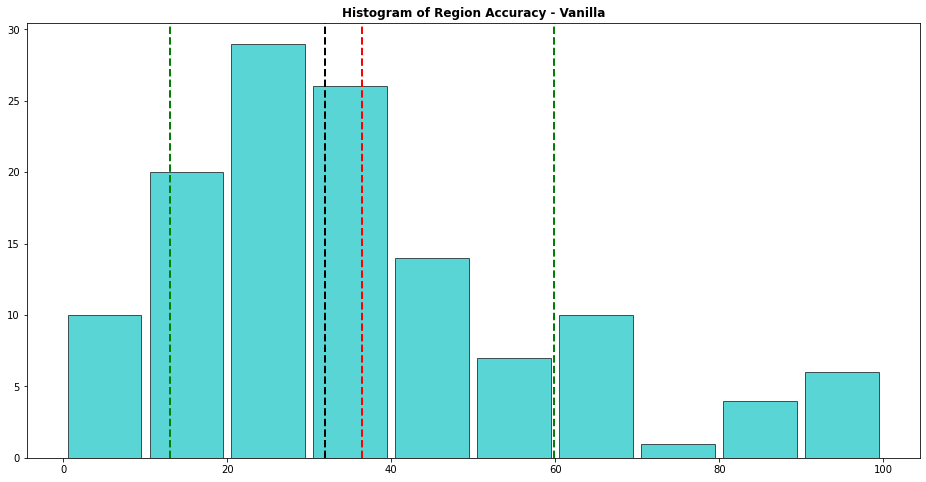

In [79]:
plt.figure(figsize=(16,8))
values_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values_vanilla, bins=10, color='c', edgecolor='k', alpha=0.65, rwidth=0.9)
plt.axvline(values_vanilla.median(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(values_vanilla.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(values_vanilla.mean() + values_vanilla.std(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(values_vanilla.mean() - values_vanilla.std(), color='green', linestyle='dashed', linewidth=2)
plt.title('Histogram of Region Accuracy - Vanilla', fontweight='bold');

#### With Random Weights

In [80]:
# Interpretability

mean_drw = df_drw[df_drw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd_drw = df_drw[df_drw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total_drw = df_drw[df_drw['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind_drw = df_drw[df_drw['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median_drw = df_drw[df_drw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v_drw = df_drw[df_drw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v_drw = df_drw[df_drw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model_drw = round(mean_drw, 2)
std_deviation_drw = round(stdd_drw, 2)
median_model_drw = round(median_drw, 2)

print(f'Model Average Interpretability: {itp_model_drw} +/- {std_deviation_drw}. With Median: {median_model_drw}')
print(f'\nMin.: {min_v_drw} | Max.: {max_v_drw}')

Model Average Interpretability: 45.4 +/- 30.11. With Median: 36.11

Min.: 0.0 | Max.: 100.0


In [81]:
# Model Accuracy

model_acc_drw = len(df_drw[df_drw['Pred. Type'] == 'malignant'])/159

print(f'Model Accuracy (%): {round(model_acc_drw*100, 2)}')

Model Accuracy (%): 91.82


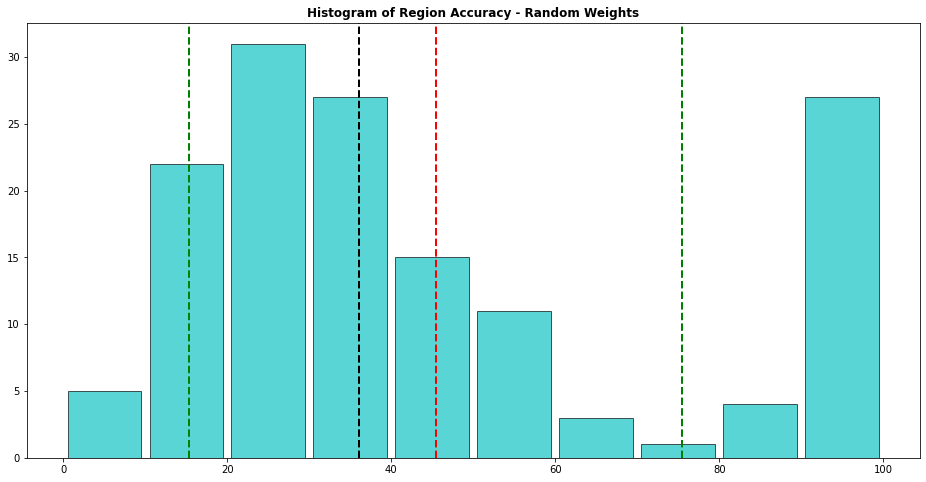

In [82]:
plt.figure(figsize=(16,8))
values_drw = df_drw[df_drw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values_drw, bins=10, color='c', edgecolor='k', alpha=0.65, rwidth=0.9)
plt.axvline(values_drw.median(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(values_drw.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(values_drw.mean() + values_drw.std(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(values_drw.mean() - values_drw.std(), color='green', linestyle='dashed', linewidth=2)
plt.title('Histogram of Region Accuracy - Random Weights', fontweight='bold');

#### With ImageNet Weights

In [83]:
# Interpretability

mean_diw = df_diw[df_diw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd_diw = df_diw[df_diw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total_diw = df_diw[df_diw['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind_diw = df_diw[df_diw['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median_diw = df_diw[df_diw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v_diw = df_diw[df_diw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v_diw = df_diw[df_diw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model_diw = round(mean_diw, 2)
std_deviation_diw = round(stdd_diw, 2)
median_model_diw = round(median_diw, 2)

print(f'Model Average Interpretability: {itp_model_diw} +/- {std_deviation_diw}. With Median: {median_model_diw}')
print(f'\nMin.: {min_v_diw} | Max.: {max_v_diw}')

Model Average Interpretability: 45.06 +/- 28.8. With Median: 39.24

Min.: 0.0 | Max.: 100.0


In [84]:
# Model Accuracy

model_acc_diw = len(df_diw[df_diw['Pred. Type'] == 'malignant'])/159

print(f'Model Accuracy (%): {round(model_acc_diw*100, 2)}')

Model Accuracy (%): 98.11


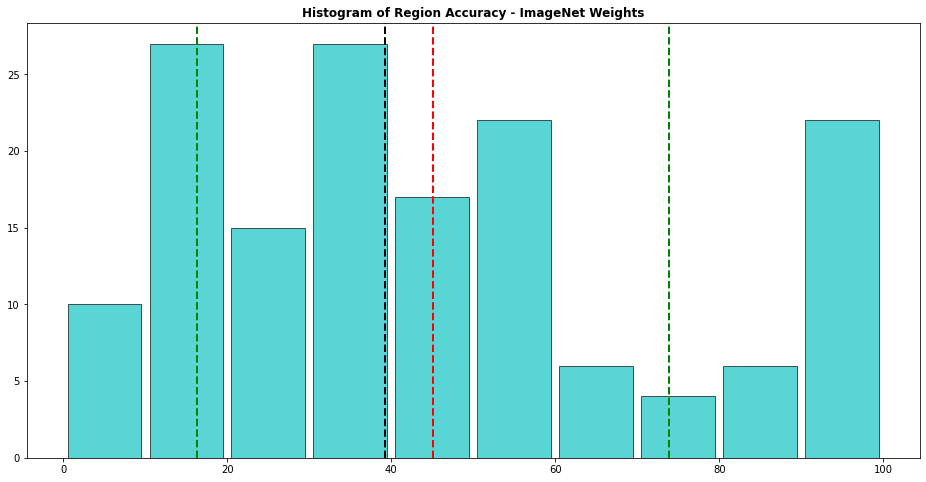

In [85]:
plt.figure(figsize=(16,8))
values_diw = df_diw[df_diw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values_diw, bins=10, color='c', edgecolor='k', alpha=0.65, rwidth=0.9)
plt.axvline(values_diw.median(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(values_diw.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(values_diw.mean() + values_diw.std(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(values_diw.mean() - values_diw.std(), color='green', linestyle='dashed', linewidth=2)
plt.title('Histogram of Region Accuracy - ImageNet Weights', fontweight='bold');

# **TEST AREA**

In [86]:
import interpretability_tester as it_test

[[0.1288 0.16   0.     0.    ]
 [0.4924 0.395  0.     0.    ]
 [0.8027 0.9775 0.     0.    ]
 [0.705  1.     0.     0.    ]]


<Figure size 720x360 with 0 Axes>

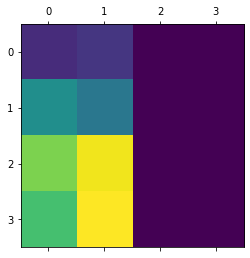

[[0.      0.      0.      0.05984]
 [0.      0.      0.2438  0.1687 ]
 [0.3684  0.7803  1.      0.5728 ]
 [0.2732  0.3887  0.54    0.1675 ]]


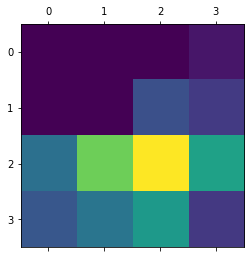

[[0.     0.     0.     0.    ]
 [1.     0.756  0.1641 0.    ]
 [0.4697 0.2448 0.     0.    ]
 [0.4106 0.     0.     0.    ]]


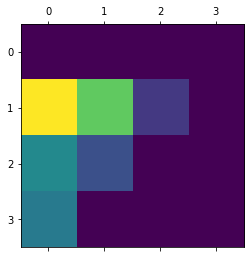

In [87]:
plt.figure(figsize=(10,5))


PATH1 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_13-07.png'
IMG1 = 'BreCaHAD_test_png/Case_13-07.png'
img1 = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG1)
heatmap1, class_1, probs1 = it_test.generate_heatmap(IMG1, model_diw, class_names)
heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG1, model_vanilla, class_names)
heatmap3, class_3, probs3 = it_test.generate_heatmap(IMG1, model_drw, class_names)


# PATH2 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_4-07.png'
# IMG2 = 'BreCaHAD_test_png/Case_4-07.png'
# img2 = tf.keras.utils.load_img(PATH2)
# img_orig_2 = tf.keras.utils.load_img(IMG2)
# heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG2, model_miw, class_names)

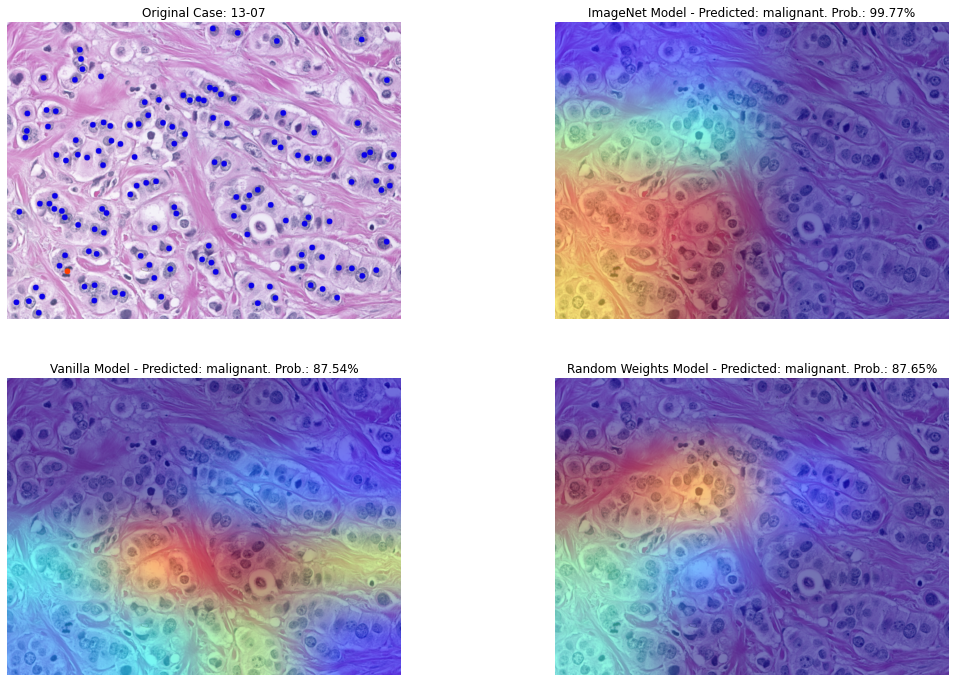

In [88]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.title(f'Original Case: 13-07')
plt.axis(False)
plt.imshow(img1)
plt.subplot(2,2,2)
plt.title(f'ImageNet Model - Predicted: {class_1}. Prob.: {round(probs1*100,2)}%')
plt.axis(False)
result1 = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, pred=class_1)
plt.subplot(2,2,3)
plt.title(f'Vanilla Model - Predicted: {class_2}. Prob.: {round(probs2*100,2)}%')
plt.axis(False)
result2 = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap2, pred=class_2)
plt.subplot(2,2,4)
plt.title(f'Random Weights Model - Predicted: {class_3}. Prob.: {round(probs3*100,2)}%')
plt.axis(False)
result3 = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap3, pred=class_3);

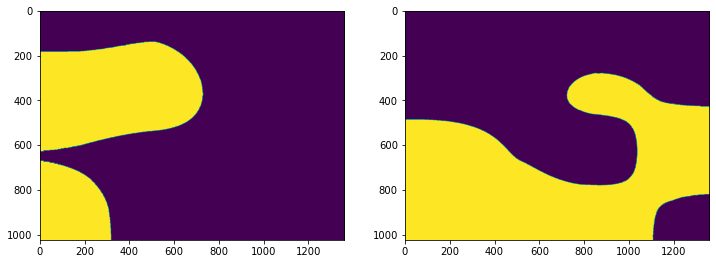

In [89]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
plt.imshow(result1)
plt.subplot(1,2,2)
plt.imshow(result2)

[[0.6943 1.     0.0514 0.    ]
 [0.4695 0.597  0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]


<Figure size 720x360 with 0 Axes>

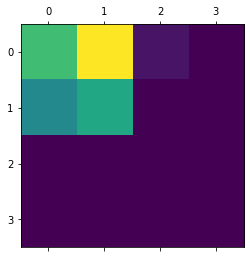

[[0.5337 0.7515 0.557  0.3098]
 [0.5205 0.783  0.7207 0.4382]
 [0.792  1.     0.778  0.373 ]
 [0.3508 0.4185 0.412  0.2268]]


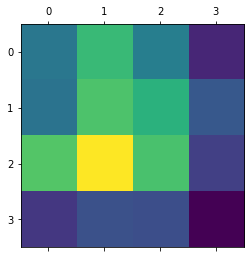

[[-0. -0. -0. -0.]
 [-0. -0. -0. -0.]
 [-0. -0. -0. -0.]
 [-0. -0. -0. -0.]]


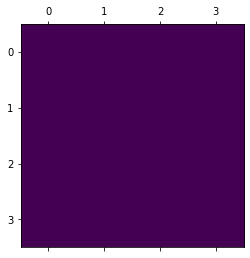

In [90]:
plt.figure(figsize=(10,5))


PATH1 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_4-07.png'
IMG1 = 'BreCaHAD_test_png/Case_4-07.png'
img1 = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG1)
heatmap1, class_1, probs1 = it_test.generate_heatmap(IMG1, model_diw, class_names)
heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG1, model_vanilla, class_names)
heatmap3, class_3, probs3 = it_test.generate_heatmap(IMG1, model_drw, class_names)


# PATH2 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_4-07.png'
# IMG2 = 'BreCaHAD_test_png/Case_4-07.png'
# img2 = tf.keras.utils.load_img(PATH2)
# img_orig_2 = tf.keras.utils.load_img(IMG2)
# heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG2, model_miw, class_names)

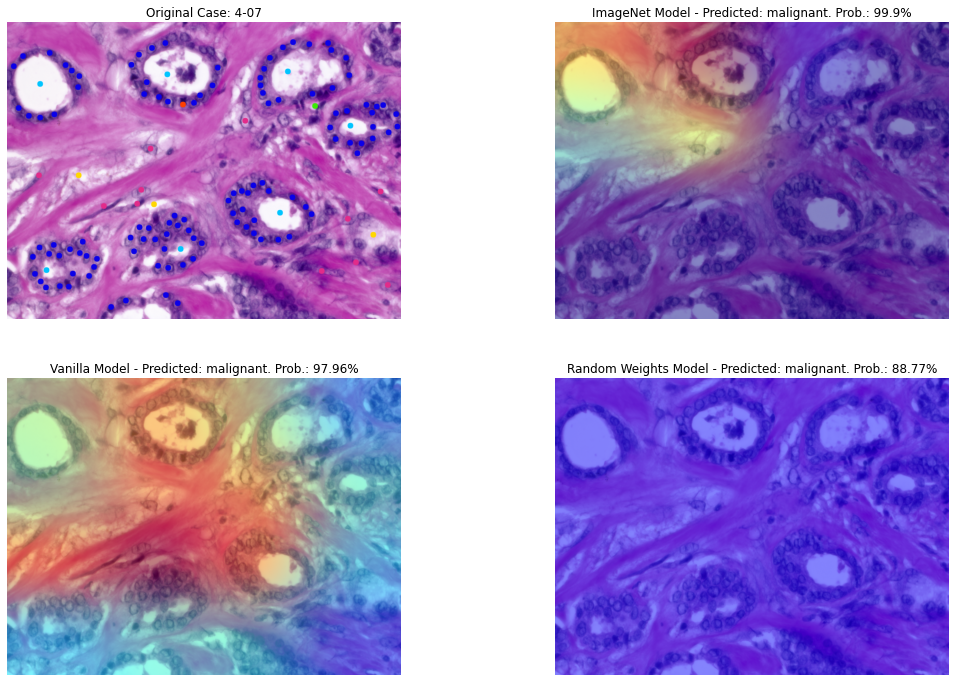

In [91]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.title(f'Original Case: 4-07')
plt.axis(False)
plt.imshow(img1)
plt.subplot(2,2,2)
plt.title(f'ImageNet Model - Predicted: {class_1}. Prob.: {round(probs1*100,2)}%')
plt.axis(False)
result_alpha = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, pred=class_1)
plt.subplot(2,2,3)
plt.title(f'Vanilla Model - Predicted: {class_2}. Prob.: {round(probs2*100,2)}%')
plt.axis(False)
result_beta = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap2, pred=class_2)
plt.subplot(2,2,4)
plt.title(f'Random Weights Model - Predicted: {class_3}. Prob.: {round(probs3*100,2)}%')
plt.axis(False)
it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap3, pred=class_3);

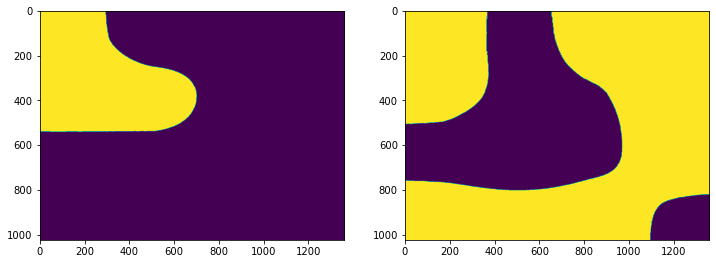

In [92]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
plt.imshow(result_alpha)
plt.subplot(1,2,2)
plt.imshow(result_beta)

[[0.1744 0.2141 0.2532 0.    ]
 [0.594  0.698  0.564  0.1956]
 [0.8154 1.     0.6846 0.1594]
 [0.596  0.7163 0.526  0.1552]]


<Figure size 720x360 with 0 Axes>

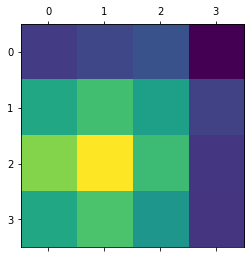

[[0.433  0.7734 0.708  0.558 ]
 [0.661  1.     0.718  0.4766]
 [0.3389 0.535  0.4155 0.309 ]
 [0.1039 0.0895 0.     0.    ]]


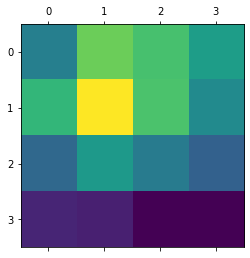

[[0.928  0.2986 0.153  0.    ]
 [0.917  0.4211 0.2058 0.    ]
 [1.     0.3923 0.3418 0.    ]
 [0.     0.     0.     0.    ]]


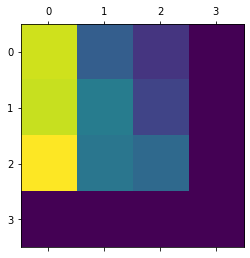

In [93]:
plt.figure(figsize=(10,5))


PATH1 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_7-05.png'
IMG1 = 'BreCaHAD_test_png/Case_7-05.png'
img1 = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG1)
heatmap1, class_1, probs1 = it_test.generate_heatmap(IMG1, model_diw, class_names)
heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG1, model_vanilla, class_names)
heatmap3, class_3, probs3 = it_test.generate_heatmap(IMG1, model_drw, class_names)


# PATH2 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_4-07.png'
# IMG2 = 'BreCaHAD_test_png/Case_4-07.png'
# img2 = tf.keras.utils.load_img(PATH2)
# img_orig_2 = tf.keras.utils.load_img(IMG2)
# heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG2, model_miw, class_names)

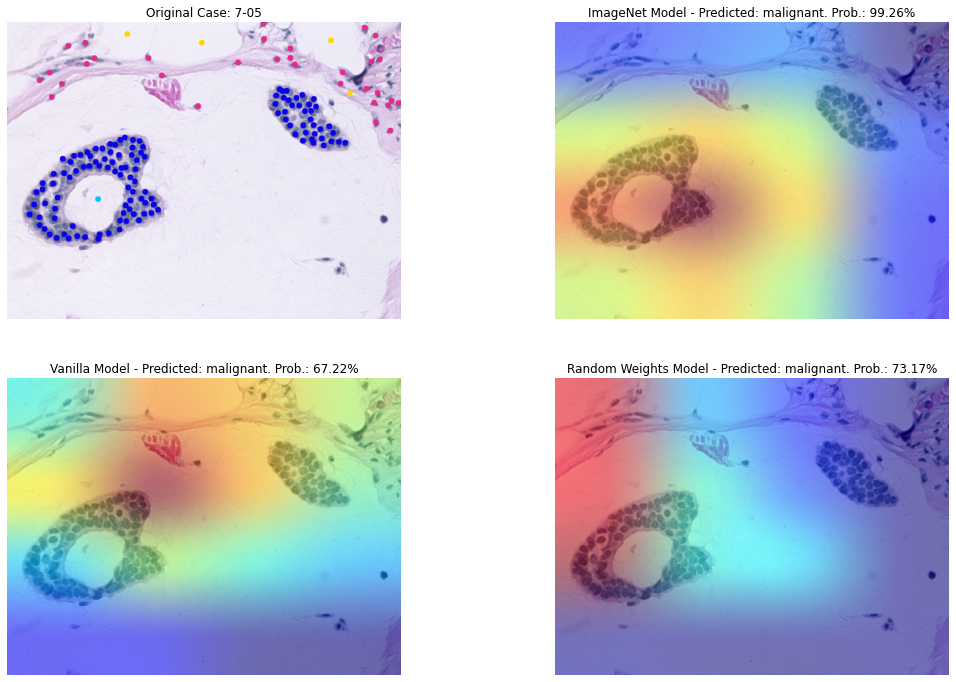

In [94]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.title(f'Original Case: 7-05')
plt.axis(False)
plt.imshow(img1)
plt.subplot(2,2,2)
plt.title(f'ImageNet Model - Predicted: {class_1}. Prob.: {round(probs1*100,2)}%')
plt.axis(False)
result_a = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, pred=class_1)
plt.subplot(2,2,3)
plt.title(f'Vanilla Model - Predicted: {class_2}. Prob.: {round(probs2*100,2)}%')
plt.axis(False)
result_b = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap2, pred=class_2)
plt.subplot(2,2,4)
plt.title(f'Random Weights Model - Predicted: {class_3}. Prob.: {round(probs3*100,2)}%')
plt.axis(False)
it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap3, pred=class_3);

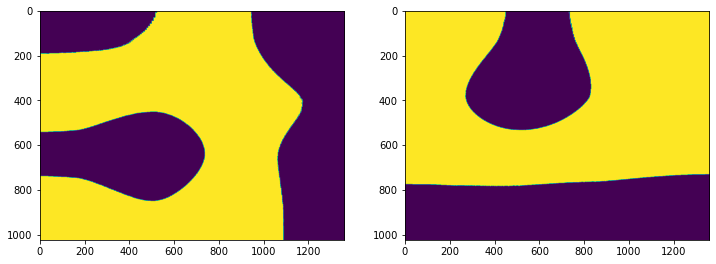

In [95]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
plt.imshow(result_a)
plt.subplot(1,2,2)
plt.imshow(result_b)